In [1]:
import os
from tqdm import tqdm
import pickle5 as pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
named_colors = list(mcolors.TABLEAU_COLORS)
import sys
sys.path.append('../../src')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
model_names = sorted(list(os.listdir('./models_R')))
errors = {}

In [3]:
model_names_resimulation = sorted(os.listdir('./resimulations_z'))
model_names_resimulation = [name for name in model_names_resimulation if name.startswith('R_')]

In [4]:
with open('./test_data_max_variance.pkl', 'rb') as file:
    test_data = pickle.load(file)
    x, dx, ddx = torch.Tensor(test_data['x']), torch.Tensor(test_data['dx']), torch.Tensor(test_data['ddx'])
    z, dz = test_data['z'], test_data['dz']
    del test_data

In [5]:
res = 512
bound = 3

ddz_results = np.zeros((10, res, res))
z_encoded = []
dz_encoded = []

z_resimulations = []

In [6]:
C = np.array(np.meshgrid(np.linspace(-bound, bound, res), np.linspace(-bound, bound, res))).T.reshape(-1, 2)

In [7]:
for i, name in enumerate(tqdm(model_names)):
    model = torch.load(os.path.join('.', 'models_R', name)).to(device).eval()

    new_z = model.autoencoder.encoder(x.to(device))
    new_dz = model.transform_time_derivative_1st_order(model.autoencoder.encoder, x.to(device), dx.to(device))

    z_encoded.append(new_z.detach().cpu().numpy())
    dz_encoded.append(new_dz.detach().cpu().numpy())

    ddz_results[i] = torch.matmul(model.library.build_snapshot(torch.Tensor(C).to(device)), model.coefficients * model.coefficient_mask).reshape(res, res).detach().cpu().numpy()

100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


In [8]:
for name in model_names_resimulation:
    with open(f'./resimulations_z/{name}', 'rb') as file:
        z_resimulations.append(pickle.load(file))

In [9]:
equations = [
    r'$-0.32 z -0.87 \sin(z)$',
    r'$0.27 z^2 -0.72\dot z^2 -1.12 z\dotz^2$',
    r'$-0.31 z - 0.85\sin(z)$',
    r'$0$',
    r'$0$',
    r'$-0.13z -0.88\sin(z)$',
    r'$0$',
    r'$0.23 -0.35 z^2$',
    r'$0.13 -0.52 z$',
    r'$0$'
]

<ipython-input-10-8c02dbf35436>:21: UserWarning: No contour levels were found within the data range.
  ax.contour(np.linspace(-bound, bound, res), np.linspace(-bound, bound, res), eq.T, [0], colors='white', linewidths=1, alpha=0.3, linestyles='dashed')
<ipython-input-10-8c02dbf35436>:21: UserWarning: No contour levels were found within the data range.
  ax.contour(np.linspace(-bound, bound, res), np.linspace(-bound, bound, res), eq.T, [0], colors='white', linewidths=1, alpha=0.3, linestyles='dashed')
<ipython-input-10-8c02dbf35436>:21: UserWarning: No contour levels were found within the data range.
  ax.contour(np.linspace(-bound, bound, res), np.linspace(-bound, bound, res), eq.T, [0], colors='white', linewidths=1, alpha=0.3, linestyles='dashed')
<ipython-input-10-8c02dbf35436>:21: UserWarning: No contour levels were found within the data range.
  ax.contour(np.linspace(-bound, bound, res), np.linspace(-bound, bound, res), eq.T, [0], colors='white', linewidths=1, alpha=0.3, linestyle

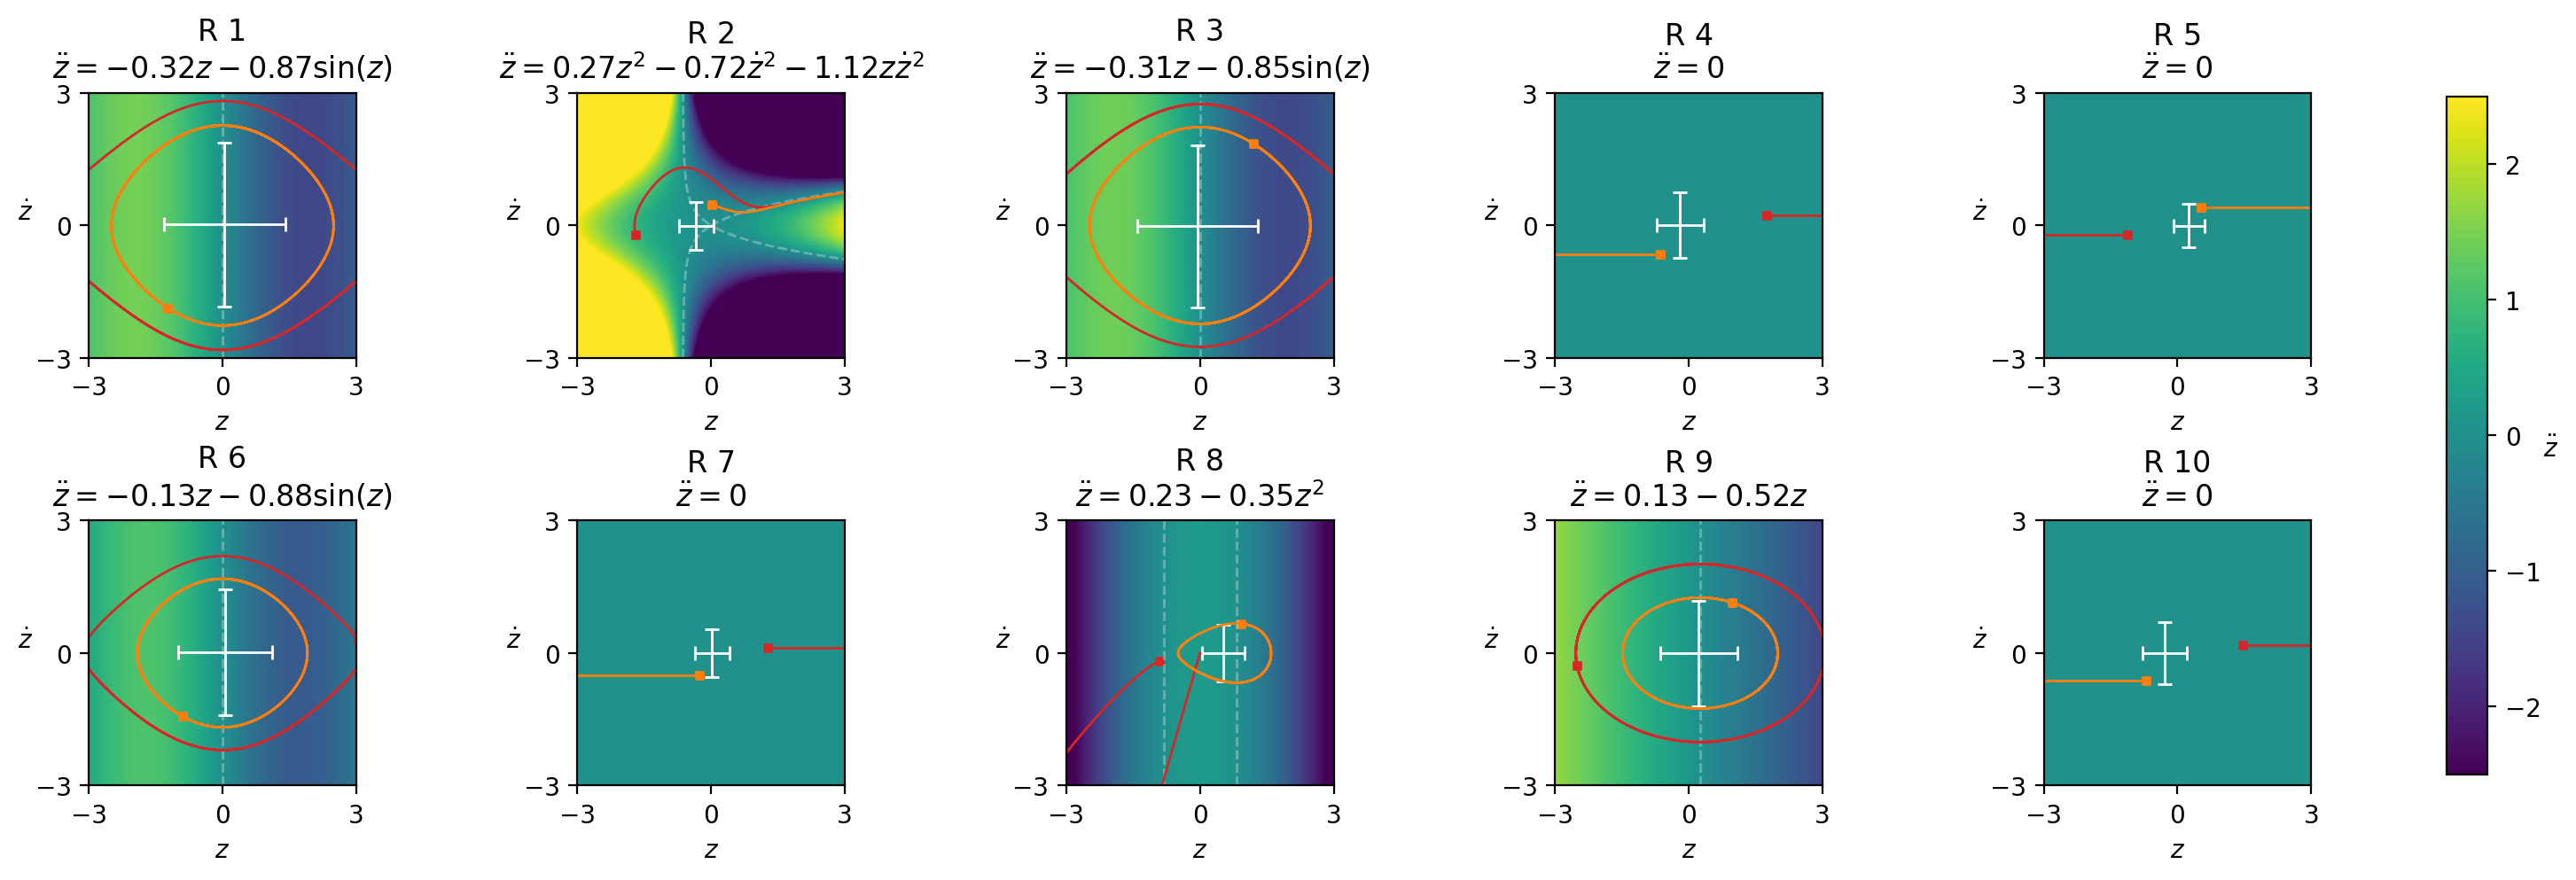

In [10]:
COLS = 5

vmin, vmax = np.min(ddz_results), np.max(ddz_results)
a = 0.9

fig, axes = plt.subplots(2, COLS, figsize=(17*a, 5*a), dpi=200)
fig.tight_layout(w_pad=7, h_pad=4.5)

for i, (eq, z_dist, dz_dist) in enumerate(zip(ddz_results, z_encoded, dz_encoded)):
    ax = axes[i//COLS][i%COLS]
    image = ax.pcolormesh(np.linspace(-bound, bound, res), np.linspace(-bound, bound, res), eq.T, vmin=-2.5, vmax=2.5, shading='auto');
    # ax.errorbar([np.mean(z)], [np.mean(dz)], [np.std(z)], [np.std(dz)], color='red', capsize=3, linewidth=1)
    ax.errorbar([np.mean(z_dist)], [np.mean(dz_dist)], [np.std(z_dist)], [np.std(dz_dist)], color='white', capsize=3, linewidth=1)

    ax.plot(z_resimulations[i][14][:, 0], z_resimulations[i][14][:, 1], color='tab:red', linewidth=1)
    ax.scatter(z_resimulations[i][14][:1, 0], z_resimulations[i][14][:1, 1], color='tab:red', s=10, marker='s')
    ax.plot(z_resimulations[i][0][:, 0], z_resimulations[i][0][:, 1], color='tab:orange', linewidth=1)
    ax.scatter(z_resimulations[i][0][:1, 0], z_resimulations[i][0][:1, 1], color='tab:orange', s=10, marker='s')

    ax.set_ylabel(r'$\dot z$', rotation='horizontal'); ax.set_xlabel(r'$z$'); ax.set_xticks([-bound, 0, bound]); ax.set_yticks([-bound, 0, bound]); ax.set_title(f'R {i+1}' + '\n' + r'$\ddot z = $' + equations[i])
    ax.contour(np.linspace(-bound, bound, res), np.linspace(-bound, bound, res), eq.T, [0], colors='white', linewidths=1, alpha=0.3, linestyles='dashed')
    ax.set_xlim(-bound, bound); ax.set_ylim(-bound, bound)

plt.subplots_adjust(right=0.85)
cax = fig.add_axes((0.9, 0.1, 0.015, 0.85))
cbar = plt.colorbar(image, cax);
cbar.set_label(r'$\ddot z$', rotation='horizontal')